In [1]:
from boards import GameBoard, MarkedBoard
from moves import NakedSingle
from solver import Solver, Solution, NotSolvableException
from analysis import MoveVector, DifficultyVector, calculate_sigmoid_difficulty, calculate_move_vector
import json

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
b = GameBoard.from_json('{"mask": "011011010011101101011100011001110111100010001111011100110001110101101110010110110", "puzzle": "138752964526948731497361258742815396619273485385694127974536812261489573853127649", "level": "1", "id": "5074306022"}')

In [3]:
for elem in b.iter_box_containing((1, 2)):
    print(elem) 

((0, 0), 1)
((0, 1), None)
((0, 2), None)
((1, 0), 5)
((1, 1), None)
((1, 2), None)
((2, 0), 4)
((2, 1), None)
((2, 2), None)


In [4]:
print(b)

+---+---+---+
|1  |7  |9 4|
|5  | 4 | 3 |
|4  | 61|2  |
+---+---+---+
|74 |  5|   |
| 19|2 3|48 |
|   |6  | 27|
+---+---+---+
|  4|53 |  2|
| 6 | 8 |  3|
|8 3|  7|  9|
+---+---+---+


In [5]:
slvr = Solver(b)

In [6]:
sln = slvr.solve()

In [7]:
calculate_sigmoid_difficulty(sln)

1.0

In [8]:
calculate_move_vector(sln)

{'Finished': 1,
 'HiddenDouble': 0,
 'HiddenSingle': 0,
 'IntersectionTrickClaiming': 0,
 'IntersectionTrickPointing': 0,
 'NakedDouble': 0,
 'NakedSingle': 47}

## Solving Boards from Web Sudoku

In [9]:
def make_solvers_from_json(file):
    boards_dicts = json.load(file)
    boards = {board_dict['id']: GameBoard.from_dict(board_dict)
          for board_dict in boards_dicts}
    solvers = {id: Solver(board) for id, board in boards.items()}
    return solvers

In [10]:
solvers = make_solvers_from_json(open('../web/evil_puzzles.json', 'rb'))

In [11]:
i = 0
for id, solver in solvers.items():
    try:
        solution = solver.solve()
        print("Board {} solution.".format(solver.game_board.id))
        #print(solution)
    except NotSolvableException:
        i += 1
        print("Board {} not solvable.".format(solver.game_board.id))
        #print(solver.game_board)
        #print(solver.solution)
print("{} Boards not solvable".format(i))

Board 4194205574 solution.
Board 8189937920 solution.
Board 1051224730 not solvable.
Board 4920426626 solution.
Board 783143326 solution.
Board 3413874002 not solvable.
Board 3867488061 solution.
Board 4864511582 solution.
Board 4782674821 solution.
Board 1576173278 solution.
Board 9018624572 solution.
Board 5895497911 solution.
Board 8480970668 solution.
Board 4077251835 solution.
Board 3213847013 solution.
Board 9472880415 solution.
Board 4740965394 solution.
Board 597747702 solution.
Board 1275927173 solution.
Board 9241041569 solution.
Board 3174258117 solution.
Board 7263354021 solution.
Board 1309397799 solution.
Board 8420791617 solution.
Board 7427180320 solution.
Board 7450213577 solution.
Board 3115319740 solution.
Board 2135987904 solution.
Board 9490571732 solution.
Board 10883142 solution.
Board 9352137436 solution.
Board 8185364990 solution.
Board 3993900278 solution.
Board 10184459370 solution.
Board 3864509407 solution.
Board 3532619440 solution.
Board 4087490698 soluti

## Experments with Solution Vectors

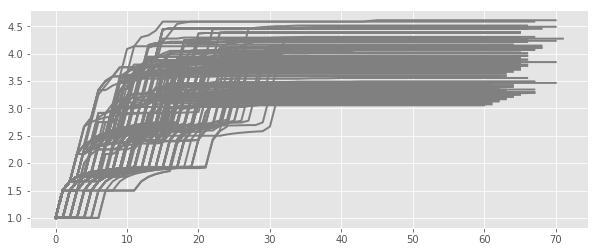

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))

def plot_many_puzzles(ax, solvers, color='grey', **kwargs):
    for id, solver in solvers.items():
        try:
            solution = solver.solve()
            dv = DifficultyVector(solution)
            dv.plot_difficulty_curve(ax, color=color, **kwargs)
        except NotSolvableException:
            pass

plot_many_puzzles(ax, solvers)
#dv.plot_difficulty_curve(ax)

## Plot Difficulty of Different Puzzles on Same Axis

In [13]:
evil_solvers = make_solvers_from_json(
    open('../web/evil_puzzles.json', 'rb'))
hard_solvers = make_solvers_from_json(
    open('../web/puzzles_level_3.json', 'rb'))
medium_solvers = make_solvers_from_json(
    open('../web/puzzles_level_2.json', 'rb'))

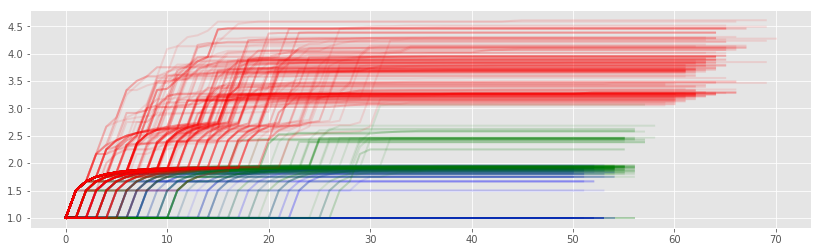

In [14]:
fig, ax = plt.subplots(figsize=(14, 4))

plot_many_puzzles(ax, medium_solvers, color='blue', alpha=0.1)
plot_many_puzzles(ax, hard_solvers, color='green', alpha=0.1)
plot_many_puzzles(ax, evil_solvers, color='red', alpha=0.1)

In [19]:
slvr = evil_solvers[list(evil_solvers.keys())[0]]
sln = slvr.solve()

In [20]:
calculate_sigmoid_difficulty(sln)

4.107843137254902

In [21]:
calculate_move_vector(sln)

{'Finished': 2,
 'HiddenDouble': 0,
 'HiddenSingle': 16,
 'IntersectionTrickClaiming': 2,
 'IntersectionTrickPointing': 5,
 'NakedDouble': 2,
 'NakedSingle': 39}

In [28]:
def safe_solve(slvr):
    try:
        return slvr.solve()
    except NotSolvableException:
        return None

evil_solutions = {pid: safe_solve(slvr) for pid, slvr in evil_solvers.items()}
evil_solutions = {pid: sln for pid, sln in evil_solutions.items() if sln is not None}


def find_hardest_puzzle(slns):
    hardest_id, hardest_sln, top_difficulty = None, None, 0.0
    for pid, sln in slns.items():
        diff = calculate_sigmoid_difficulty(sln)
        if diff > top_difficulty:
            hardest_id, hardest_sln, top_difficulty = pid, sln, diff
    return hardest_id, hardest_sln, top_difficulty

hardest_id, hardest_sln, top_difficulty = find_hardest_puzzle(evil_solutions)

In [30]:
hardest_id, calculate_move_vector(hardest_sln), top_difficulty

('2135987904',
 {'Finished': 4,
  'HiddenDouble': 2,
  'HiddenSingle': 9,
  'IntersectionTrickClaiming': 2,
  'IntersectionTrickPointing': 7,
  'NakedDouble': 1,
  'NakedSingle': 47},
 4.6083333333333325)

In [34]:
print(evil_solvers[hardest_id].game_board)

+---+---+---+
|4  |  1|   |
|9 5|  2|   |
|   |9 8| 63|
+---+---+---+
|  1|   | 2 |
|6  | 3 |  4|
| 5 |   |9  |
+---+---+---+
|27 |6 5|   |
|   |4  |8 7|
|   |8  |  2|
+---+---+---+
